## Import of packages and data

In [24]:
import pandas as pd
import seaborn as sns

In [25]:
client = pd.read_csv('../data/client.csv')

client.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [26]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41919 entries, 0 to 41918
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_type        41919 non-null  int64  
 1   county              41919 non-null  int64  
 2   eic_count           41919 non-null  int64  
 3   installed_capacity  41919 non-null  float64
 4   is_business         41919 non-null  int64  
 5   date                41919 non-null  object 
 6   data_block_id       41919 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 2.2+ MB


In [27]:
client.date = pd.to_datetime(client.date)

client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41919 entries, 0 to 41918
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   product_type        41919 non-null  int64         
 1   county              41919 non-null  int64         
 2   eic_count           41919 non-null  int64         
 3   installed_capacity  41919 non-null  float64       
 4   is_business         41919 non-null  int64         
 5   date                41919 non-null  datetime64[ns]
 6   data_block_id       41919 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 2.2 MB


In [28]:
# categoricals?
display(client.product_type.unique())
display(client.is_business.unique())
display(client.county.unique())

array([1, 2, 3, 0])

array([0, 1])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

<Axes: xlabel='date', ylabel='data_block_id'>

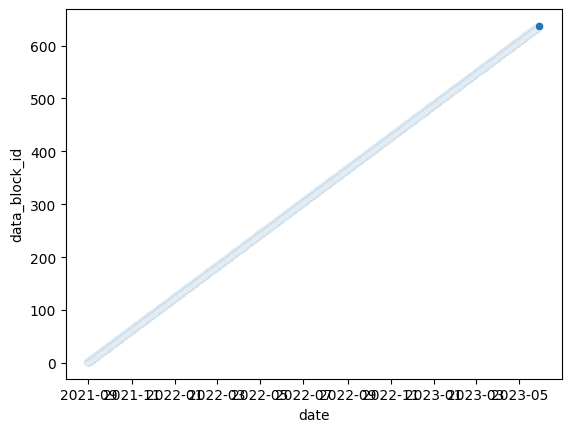

In [29]:
sns.scatterplot(x = client.date, y = client.data_block_id)

In [30]:
min(client.date)

Timestamp('2021-09-01 00:00:00')

In [31]:
max(client.date)

Timestamp('2023-05-29 00:00:00')

In [32]:
client.data_block_id.nunique()

636

    First day is '2021-09-01 00:00:00', last day is '2023-05-29 00:00:00'. There are 636 unique days, and data_block_id corresponds to date. 

In [33]:
client.date.nunique()

636

In [34]:
electricity_prices = pd.read_csv('../data/electricity_prices.csv')

electricity_prices.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [35]:
electricity_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   forecast_date  15286 non-null  object 
 1   euros_per_mwh  15286 non-null  float64
 2   origin_date    15286 non-null  object 
 3   data_block_id  15286 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 477.8+ KB


In [36]:
electricity_prices.forecast_date = pd.to_datetime(electricity_prices.forecast_date)
electricity_prices.origin_date = pd.to_datetime(electricity_prices.origin_date)

electricity_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   forecast_date  15286 non-null  datetime64[ns]
 1   euros_per_mwh  15286 non-null  float64       
 2   origin_date    15286 non-null  datetime64[ns]
 3   data_block_id  15286 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 477.8 KB


In [37]:
electricity_prices.nunique()

forecast_date    15286
euros_per_mwh    11025
origin_date      15286
data_block_id      637
dtype: int64

In [38]:
electricity_prices.forecast_date.unique()

<DatetimeArray>
['2021-09-01 00:00:00', '2021-09-01 01:00:00', '2021-09-01 02:00:00',
 '2021-09-01 03:00:00', '2021-09-01 04:00:00', '2021-09-01 05:00:00',
 '2021-09-01 06:00:00', '2021-09-01 07:00:00', '2021-09-01 08:00:00',
 '2021-09-01 09:00:00',
 ...
 '2023-05-30 14:00:00', '2023-05-30 15:00:00', '2023-05-30 16:00:00',
 '2023-05-30 17:00:00', '2023-05-30 18:00:00', '2023-05-30 19:00:00',
 '2023-05-30 20:00:00', '2023-05-30 21:00:00', '2023-05-30 22:00:00',
 '2023-05-30 23:00:00']
Length: 15286, dtype: datetime64[ns]

    Electricity price forecast are available for each hour of the day (637 days * 24 hours = 15286 unique datetimes) (for 637 days, one day more than client data; somewhere there are 2h missing)




In [39]:
forecast_weather = pd.read_csv('../data/forecast_weather.csv')

forecast_weather.head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 00:00:00+00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 00:00:00+00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 00:00:00+00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 00:00:00+00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 00:00:00+00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0


In [40]:
forecast_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424512 entries, 0 to 3424511
Data columns (total 18 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   latitude                           float64
 1   longitude                          float64
 2   origin_datetime                    object 
 3   hours_ahead                        int64  
 4   temperature                        float64
 5   dewpoint                           float64
 6   cloudcover_high                    float64
 7   cloudcover_low                     float64
 8   cloudcover_mid                     float64
 9   cloudcover_total                   float64
 10  10_metre_u_wind_component          float64
 11  10_metre_v_wind_component          float64
 12  data_block_id                      int64  
 13  forecast_datetime                  object 
 14  direct_solar_radiation             float64
 15  surface_solar_radiation_downwards  float64
 16  snowfall          

In [41]:
forecast_weather.origin_datetime = pd.to_datetime(forecast_weather.origin_datetime)
forecast_weather.forecast_datetime = pd.to_datetime(forecast_weather.forecast_datetime)

forecast_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424512 entries, 0 to 3424511
Data columns (total 18 columns):
 #   Column                             Dtype              
---  ------                             -----              
 0   latitude                           float64            
 1   longitude                          float64            
 2   origin_datetime                    datetime64[ns, UTC]
 3   hours_ahead                        int64              
 4   temperature                        float64            
 5   dewpoint                           float64            
 6   cloudcover_high                    float64            
 7   cloudcover_low                     float64            
 8   cloudcover_mid                     float64            
 9   cloudcover_total                   float64            
 10  10_metre_u_wind_component          float64            
 11  10_metre_v_wind_component          float64            
 12  data_block_id                      int64  

In [42]:
forecast_weather.nunique()

latitude                                   8
longitude                                 14
origin_datetime                          637
hours_ahead                               48
temperature                           400895
dewpoint                              439461
cloudcover_high                       212178
cloudcover_low                        408609
cloudcover_mid                        308004
cloudcover_total                      698385
10_metre_u_wind_component            3166997
10_metre_v_wind_component            3142161
data_block_id                            637
forecast_datetime                      15312
direct_solar_radiation               1199360
surface_solar_radiation_downwards    1496773
snowfall                              256201
total_precipitation                   540661
dtype: int64

In [43]:
# def print_block(dbid):
#     display("TRAIN", train[train['data_block_id'] == dbid])
#     display("FORC WEATHER", forecast_weather[forecast_weather['data_block_id'] == dbid])
#     display("CLIENT", client[client['data_block_id'] == dbid])
#     display("HIST WEATHER", historical_weather[historical_weather['data_block_id'] == dbid])
#     display("E PRICES", electricity_prices[electricity_prices['data_block_id'] == dbid])
#     display("G PRICES", gas_prices[gas_prices['data_block_id'] == dbid])

# print_block(10)

NameError: name 'train' is not defined

In [44]:
forecast_weather.groupby(['latitude', 'longitude']).nunique()

origin_datetime  hours_ahead  temperature  dewpoint  \
latitude longitude                                                        
57.6     21.7                   637           48        27706     28047   
         22.2                   637           48        28285     28292   
         22.7                   637           48        27799     28120   
         23.2                   637           48        27587     28120   
         23.7                   637           48        27697     28045   
...                             ...          ...          ...       ...   
59.7     26.2                   637           48        27959     28170   
         26.7                   637           48        28019     28199   
         27.2                   637           48        28033     28129   
         27.7                   637           48        28156     28283   
         28.2                   637           48        28495     28373   

                    cloudcover_high  cloudcover_low  cloudcover_mid  \
latitude longitude                                                    
57.6     21.7                 10902           14794           13125   
         22.2                 11118           15006           13505   
         22.7                 11000           14869           13640   
         23.2                 10821           14289           13280   
         23.7                 11010           14380           13396   
...                             ...             ...             ...   
59.7     26.2                 11356           14511           13565   
         26.7                 11082           14412           13420   
         27.2                 11387           14400           13519   
         27.7                 10929           14201           13348   
         28.2                 11102           14822           13779   

                    cloudcover_total  10_metre_u_wind_component  \
latitude longitude                                                
57.6     21.7                  16896                      30563   
         22.2                  17130                      30548   
         22.7                  17178                      30554   
         23.2                  16737                      30558   
         23.7                  16817                      30561   
...                              ...                        ...   
59.7     26.2                  16080                      30561   
         26.7                  15878                      30563   
         27.2                  15858                      30551   
         27.7                  15712                      30555   
         28.2                  16164                      30542   

                    10_metre_v_wind_component  data_block_id  \
latitude longitude                                             
57.6     21.7                           30551            637   
         22.2                           30550            637   
         22.7                           30556            637   
         23.2                           30556            637   
         23.7                           30560            637   
...                                       ...            ...   
59.7     26.2                           30559            637   
         26.7                           30560            637   
         27.2                           30563            637   
         27.7                           30556            637   
         28.2                           30553            637   

                    forecast_datetime  direct_solar_radiation  \
latitude longitude                                              
57.6     21.7                   15312                   14747   
         22.2                   15312                   14555   
         22.7                   15312                   14561   
         23.2                   15312                   14670   
         23.7            

    There are 112 unique combinations of lat and long (unique weather stations). 
    So for each forecast_date, there are 112 observations (one from each station). 


In [45]:
forecast_weather.hours_ahead.nunique()

48

In [46]:
forecast_weather.origin_datetime.nunique()

637

In [47]:
forecast_weather.groupby('origin_datetime').forecast_datetime.size()/112

origin_datetime
2021-09-01 00:00:00+00:00    48.0
2021-09-02 00:00:00+00:00    48.0
2021-09-03 00:00:00+00:00    48.0
2021-09-04 00:00:00+00:00    48.0
2021-09-05 00:00:00+00:00    48.0
                             ... 
2023-05-26 00:00:00+00:00    48.0
2023-05-27 00:00:00+00:00    48.0
2023-05-28 00:00:00+00:00    48.0
2023-05-29 00:00:00+00:00    48.0
2023-05-30 00:00:00+00:00    48.0
Name: forecast_datetime, Length: 637, dtype: float64

In [48]:
forecast_weather.groupby(['origin_datetime', 'forecast_datetime']).count()

latitude  longitude  \
origin_datetime           forecast_datetime                                
2021-09-01 00:00:00+00:00 2021-09-01 01:00:00+00:00       112        112   
                          2021-09-01 02:00:00+00:00       112        112   
                          2021-09-01 03:00:00+00:00       112        112   
                          2021-09-01 04:00:00+00:00       112        112   
                          2021-09-01 05:00:00+00:00       112        112   
...                                                       ...        ...   
2023-05-30 00:00:00+00:00 2023-05-31 20:00:00+00:00       112        112   
                          2023-05-31 21:00:00+00:00       112        112   
                          2023-05-31 22:00:00+00:00       112        112   
                          2023-05-31 23:00:00+00:00       112        112   
                          2023-06-01 00:00:00+00:00       112        112   

                                                     hours_ahead  temperature  \
origin_datetime           forecast_datetime                                     
2021-09-01 00:00:00+00:00 2021-09-01 01:00:00+00:00          112          112   
                          2021-09-01 02:00:00+00:00          112          112   
                          2021-09-01 03:00:00+00:00          112          112   
                          2021-09-01 04:00:00+00:00          112          112   
                          2021-09-01 05:00:00+00:00          112          112   
...                                                          ...          ...   
2023-05-30 00:00:00+00:00 2023-05-31 20:00:00+00:00          112          112   
                          2023-05-31 21:00:00+00:00          112          112   
                          2023-05-31 22:00:00+00:00          112          112   
                          2023-05-31 23:00:00+00:00          112          112   
                          2023-06-01 00:00:00+00:00          112          112   

                                                     dewpoint  \
origin_datetime           forecast_datetime                     
2021-09-01 00:00:00+00:00 2021-09-01 01:00:00+00:00       112   
                          2021-09-01 02:00:00+00:00       112   
                          2021-09-01 03:00:00+00:00       112   
                          2021-09-01 04:00:00+00:00       112   
                          2021-09-01 05:00:00+00:00       112   
...                                                       ...   
2023-05-30 00:00:00+00:00 2023-05-31 20:00:00+00:00       112   
                          2023-05-31 21:00:00+00:00       112   
                          2023-05-31 22:00:00+00:00       112   
                          2023-05-31 23:00:00+00:00       112   
                          2023-06-01 00:00:00+00:00       112   

                                                     cloudcover_high  \
origin_datetime           forecast_datetime                            
2021-09-01 00:00:00+00:00 2021-09-01 01:00:00+00:00              112   
                          2021-09-01 02:00:00+00:00              112   
                          2021-09-01 03:00:00+00:00              112   
                          2021-09-01 04:00:00+00:00              112   
                          2021-09-01 05:00:00+00:00              112   
...                                                              ...   
2023-05-30 00:00:00+00:00 2023-05-31 20:00:00+00:00              112   
                          2023-05-31 21:00:00+00:00              112   
                          2023-05-31 22:00:00+00:00              112   
                          2023-05-31 23:00:00+00:00              112   
                          2023-06-01 00:00:00+00:00              112   

                                                     cloudcover_low  \
origin_datetime           forecast_datetime                           
2021-09-01 00:00:00+00:00 2021-09-01 01:00:00+00:00             112   
              

In [49]:
gas_prices = pd.read_csv('../data/gas_prices.csv')

gas_prices.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


In [50]:
gas_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   forecast_date          637 non-null    object 
 1   lowest_price_per_mwh   637 non-null    float64
 2   highest_price_per_mwh  637 non-null    float64
 3   origin_date            637 non-null    object 
 4   data_block_id          637 non-null    int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 25.0+ KB


In [51]:
gas_prices.forecast_date = pd.to_datetime(gas_prices.forecast_date)
gas_prices.origin_date = pd.to_datetime(gas_prices.origin_date)

gas_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   forecast_date          637 non-null    datetime64[ns]
 1   lowest_price_per_mwh   637 non-null    float64       
 2   highest_price_per_mwh  637 non-null    float64       
 3   origin_date            637 non-null    datetime64[ns]
 4   data_block_id          637 non-null    int64         
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 25.0 KB


In [52]:
gas_prices.describe()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
count,637,637.000000,637.000000,637,637.000000
mean,2022-07-16 00:00:00,95.036750,107.754631,2022-07-15 00:00:00,319.000000
min,2021-09-01 00:00:00,28.100000,34.000000,2021-08-31 00:00:00,1.000000
25%,2022-02-07 00:00:00,60.000000,67.530000,2022-02-06 00:00:00,160.000000
50%,2022-07-16 00:00:00,85.210000,93.470000,2022-07-15 00:00:00,319.000000
75%,2022-12-22 00:00:00,109.000000,130.740000,2022-12-21 00:00:00,478.000000
max,2023-05-30 00:00:00,250.000000,305.000000,2023-05-29 00:00:00,637.000000
std,NaN,47.552295,54.743666,NaN,184.030342


In [53]:
historical_weather = pd.read_csv('../data/historical_weather.csv')

historical_weather.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,57.6,21.7,1
1,2021-09-01 00:00:00,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,57.6,22.2,1
2,2021-09-01 00:00:00,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,57.6,22.7,1
3,2021-09-01 00:00:00,15.4,13.0,0.0,0.0,1014.4,4,2,4,0,7.111111,349,0.0,0.0,0.0,57.6,23.2,1
4,2021-09-01 00:00:00,15.9,12.6,0.0,0.0,1013.8,12,7,0,20,8.388889,360,0.0,0.0,0.0,57.6,23.7,1


In [54]:
historical_weather.datetime = pd.to_datetime(historical_weather.datetime)

historical_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710800 entries, 0 to 1710799
Data columns (total 18 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   datetime                datetime64[ns]
 1   temperature             float64       
 2   dewpoint                float64       
 3   rain                    float64       
 4   snowfall                float64       
 5   surface_pressure        float64       
 6   cloudcover_total        int64         
 7   cloudcover_low          int64         
 8   cloudcover_mid          int64         
 9   cloudcover_high         int64         
 10  windspeed_10m           float64       
 11  winddirection_10m       int64         
 12  shortwave_radiation     float64       
 13  direct_solar_radiation  float64       
 14  diffuse_radiation       float64       
 15  latitude                float64       
 16  longitude               float64       
 17  data_block_id           int64         
dtypes:

In [55]:
historical_weather.isnull().sum()

datetime                  0
temperature               0
dewpoint                  0
rain                      0
snowfall                  0
surface_pressure          0
cloudcover_total          0
cloudcover_low            0
cloudcover_mid            0
cloudcover_high           0
windspeed_10m             0
winddirection_10m         0
shortwave_radiation       0
direct_solar_radiation    0
diffuse_radiation         0
latitude                  0
longitude                 0
data_block_id             0
dtype: int64

In [56]:
train = pd.read_csv('../data/train.csv')

train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


In [63]:
train.datetime = pd.to_datetime(train.datetime, format='%Y-%m-%d %H:%M:%S')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   county              int64         
 1   is_business         int64         
 2   product_type        int64         
 3   target              float64       
 4   is_consumption      int64         
 5   datetime            datetime64[ns]
 6   data_block_id       int64         
 7   row_id              int64         
 8   prediction_unit_id  int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 138.6 MB


In [64]:
train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01,0,0,0
1,0,0,1,96.590,1,2021-09-01,0,1,0
2,0,0,2,0.000,0,2021-09-01,0,2,1
3,0,0,2,17.314,1,2021-09-01,0,3,1
4,0,0,3,2.904,0,2021-09-01,0,4,2


In [60]:
train.datetime[1000]

Timestamp('2021-09-01 08:00:00')

In [65]:
train.isnull().sum()

county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64

In [66]:
train.groupby('is_consumption').agg({'target': lambda x: x.isnull().sum()})

,target
is_consumption,
0,264
1,264


In [67]:
train[train.target.isnull()]

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
178938,0,0,1,NaN,0,2021-10-31 03:00:00,60,178938,0
178939,0,0,1,NaN,1,2021-10-31 03:00:00,60,178939,0
178940,0,0,2,NaN,0,2021-10-31 03:00:00,60,178940,1
178941,0,0,2,NaN,1,2021-10-31 03:00:00,60,178941,1
178942,0,0,3,NaN,0,2021-10-31 03:00:00,60,178942,2
...,...,...,...,...,...,...,...,...,...
1806379,15,1,0,NaN,1,2023-03-26 03:00:00,571,1806379,64
1806380,15,1,1,NaN,0,2023-03-26 03:00:00,571,1806380,59
1806381,15,1,1,NaN,1,2023-03-26 03:00:00,571,1806381,59
1806382,15,1,3,NaN,0,2023-03-26 03:00:00,571,1806382,60


    There seems to be no pattern in the null values in target column. This indicates we can drop these rows

In [68]:
weather_station_to_county_mapping = pd.read_csv('../data/weather_station_to_county_mapping.csv')

weather_station_to_county_mapping.head()

,county_name,longitude,latitude,county
0,NaN,21.7,57.6,NaN
1,NaN,21.7,57.9,NaN
2,NaN,21.7,58.2,NaN
3,NaN,21.7,58.5,NaN
4,NaN,21.7,58.8,NaN


In [69]:
weather_station_to_county_mapping.county.unique()

array([nan, 10.,  1.,  7.,  6.,  9.,  0., 14.,  3., 13., 11.,  4.,  5.,
       15.,  8.,  2.])

In [70]:
weather_station_to_county_mapping.county_name.unique()

array([nan, 'Saaremaa', 'Hiiumaa', 'Pärnumaa', 'Läänemaa', 'Raplamaa',
       'Harjumaa', 'Viljandimaa', 'Järvamaa', 'Valgamaa', 'Tartumaa',
       'Jõgevamaa', 'Lääne-Virumaa', 'Võrumaa', 'Põlvamaa', 'Ida-Virumaa'],
      dtype=object)

https://www.kaggle.com/code/fabiendaniel/mapping-locations-and-county-codes/notebook  for county codes
Here, they remove the 'maa' appendix from the county names. but is this really needed?

## MERGING (now we merge everything to train)

In [71]:
train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01,0,0,0
1,0,0,1,96.590,1,2021-09-01,0,1,0
2,0,0,2,0.000,0,2021-09-01,0,2,1
3,0,0,2,17.314,1,2021-09-01,0,3,1
4,0,0,3,2.904,0,2021-09-01,0,4,2


In [73]:
client.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [75]:
print(client.size, train.size)

293433 18165168


In [115]:
# merged = train.copy()

#merged = merged.join(client, on='data_block_id', how='left', rsuffix= '_client')

merged_df = pd.merge(train, client, on=['data_block_id', 'county', 'is_business', 'product_type'], how='left')

#merged_df.query('100 < data_block_id < 500').isnull().sum()

#display(merged_df.head(100))
#display(merged_df.tail(100))
merged_df[pd.isna(merged_df['date'])]


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,eic_count,installed_capacity,date
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,NaN,NaN,NaT
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,NaN,NaN,NaT
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,NaN,NaN,NaT
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,NaN,NaN,NaT
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...
1937729,10,1,2,209.316,1,2023-05-06 21:00:00,612,1937729,41,NaN,NaN,NaT
1937864,10,1,2,0.000,0,2023-05-06 22:00:00,612,1937864,41,NaN,NaN,NaT
1937865,10,1,2,214.079,1,2023-05-06 22:00:00,612,1937865,41,NaN,NaN,NaT
1938000,10,1,2,0.000,0,2023-05-06 23:00:00,612,1938000,41,NaN,NaN,NaT


In [103]:
merged_df[merged_df.eic_count.isnull()].data_block_id.value_counts()

data_block_id
0      2928
1      2928
30      144
31      144
122     144
123     144
154      96
607      96
153      96
584      48
540      48
533      48
541      48
572      48
573      48
580      48
583      48
596      48
590      48
591      48
595      48
519      48
602      48
603      48
606      48
608      48
611      48
532      48
458      48
518      48
514      48
91       48
92       48
172      48
173      48
203      48
204      48
215      48
216      48
273      48
274      48
365      48
366      48
395      48
396      48
426      48
427      48
513      48
612      48
Name: count, dtype: int64

In [96]:
print(set(client.date.dt.date) ^ set(train.datetime.dt.date))
print(set(train.data_block_id) ^ set(client.data_block_id))

{datetime.date(2023, 5, 31), datetime.date(2023, 5, 30)}
{0, 1}


In [80]:
def print_block(dbid):
    display("TRAIN", train[train['data_block_id'] == dbid])
#     display("FORC WEATHER", forecast_weather[forecast_weather['data_block_id'] == dbid])
    display("CLIENT", client[client['data_block_id'] == dbid])
#     display("HIST WEATHER", historical_weather[historical_weather['data_block_id'] == dbid])
#     display("E PRICES", electricity_prices[electricity_prices['data_block_id'] == dbid])
#     display("G PRICES", gas_prices[gas_prices['data_block_id'] == dbid])

print_block(10)

'TRAIN'

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
29280,0,0,1,0.000,0,2021-09-11 00:00:00,10,29280,0
29281,0,0,1,109.095,1,2021-09-11 00:00:00,10,29281,0
29282,0,0,2,0.000,0,2021-09-11 00:00:00,10,29282,1
29283,0,0,2,17.503,1,2021-09-11 00:00:00,10,29283,1
29284,0,0,3,0.077,0,2021-09-11 00:00:00,10,29284,2
...,...,...,...,...,...,...,...,...,...
32203,15,0,3,76.522,1,2021-09-11 23:00:00,10,32203,58
32204,15,1,1,0.100,0,2021-09-11 23:00:00,10,32204,59
32205,15,1,1,17.543,1,2021-09-11 23:00:00,10,32205,59
32206,15,1,3,0.000,0,2021-09-11 23:00:00,10,32206,60


'CLIENT'

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
488,1,0,108,952.89,0,2021-09-09,10
489,2,0,17,166.40,0,2021-09-09,10
490,3,0,687,7199.88,0,2021-09-09,10
491,0,0,5,400.00,1,2021-09-09,10
492,1,0,43,1411.00,1,2021-09-09,10
...,...,...,...,...,...,...,...
544,3,14,67,3114.60,1,2021-09-09,10
545,1,15,10,83.20,0,2021-09-09,10
546,3,15,61,918.20,0,2021-09-09,10
547,1,15,7,325.00,1,2021-09-09,10


There is a problem with NULL values after merging. one source are the start and end dates, but we don't know whats happening in between and whether this is problematic.
Maybe some client data is sporadically missing?



In [107]:
gas_prices.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


In [116]:
# next merge: gas

merged_df = pd.merge(merged_df, gas_prices, on=['data_block_id'], how='left', suffixes=(None, '_gas_prices'))
# why do suffixes not work??

merged_df.tail()


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,eic_count,installed_capacity,date,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,15.0,620.0,2023-05-29,2023-05-30,29.0,34.0,2023-05-29
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,20.0,624.5,2023-05-29,2023-05-30,29.0,34.0,2023-05-29
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,20.0,624.5,2023-05-29,2023-05-30,29.0,34.0,2023-05-29
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,55.0,2188.2,2023-05-29,2023-05-30,29.0,34.0,2023-05-29
2018351,15,1,3,196.240,1,2023-05-31 23:00:00,637,2018351,60,55.0,2188.2,2023-05-29,2023-05-30,29.0,34.0,2023-05-29


## EDA